In [ ]:
!pip3 install torch torchvision


Carpeta de drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Lee la carpeta Ms-Pacman-V0 desde el drive


In [2]:
!ls gdrive/'My Drive'/Ms-Pacman-V0

LICENSE  PacMan-DQN.ipynb  README.md


Librerias necesarias para entrenar al pacman

In [3]:
import gym
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import random
import datetime

In [64]:
reward_number = 0.37

Clase de una Red neuronal Convulosional

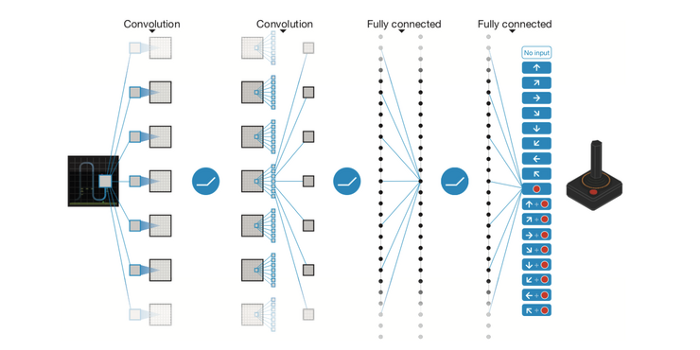

In [65]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convolution1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
        self.convolution3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7)
        self.fc1 = nn.Linear(in_features=1792, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=256)
        self.fc4 = nn.Linear(in_features=256, out_features=32)
        self.fc5 = nn.Linear(in_features=32, out_features=9)
   
    def forward(self, x):
        x = x.cuda()
        x = F.relu(F.max_pool2d(self.convolution1(x), 3))
        x = F.relu(F.max_pool2d(self.convolution2(x), 3))
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2))
        x = x.reshape(x.size(0), - 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

Carga el modelo CNN

In [66]:
model = CNN()

In [67]:
model = model.cuda()

In [92]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

Clase que define el algoritmo de aprendizaje por refuerzo DQN

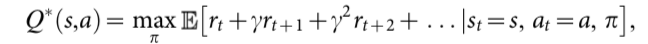

In [97]:
class DQNAgent:
    def __init__(self, action_size = 9):
        self.state_size = 4
        self.action_size = action_size
        self.memory_n = deque(maxlen=2000)
        self.memory_p = deque(maxlen=2000)
        self.gamma = 1.0    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.5
        self.epsilon_decay = 0.995
        self.learning_rate = 0.1
        self.model = model

    def remember(self, state, action, reward, next_state, done):
        if reward == 0:
            self.memory_p.append((state, action, reward, next_state, done))
        else:
            self.memory_n.append((state, action, reward, next_state, done))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state_tensor = torch.from_numpy(state).float()
        act_values = self.model(state_tensor).cpu().detach().numpy()
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        if len(agent.memory_n) > batch_size / 2:
            print("Negative batch ready:")
            minibatch_n = random.sample(self.memory_n, 5)
            minibatch_p = random.sample(self.memory_p, 59)
            minibatch = random.sample((minibatch_p+minibatch_n), batch_size)
        else:
            minibatch = random.sample(self.memory_p, batch_size)
        for state, action, reward, next_state, done in minibatch:
            # reward = 0.001 if reward == 0 else 0.001
            ns_model = self.model(torch.from_numpy(next_state).float()).cpu().detach().numpy()
            if reward == 0:
                reward = 1.0001
                # print("Reward:", reward)
                target = reward * np.amax(ns_model[0])
                # print("target: ", target)
                target_f = ns_model
                # print("target_f: ", target_f)
                # print('Argmax: ', np.argmax(ns_model[0]))
                target_f[0][np.argmax(ns_model[0])] = target 
                # print("target_f[0][np.argmax(ns_model[0])]: ", target_f)            
            else:
                reward = reward_number
                # print("Reward:", reward)
                target = reward * np.amin(ns_model[0])
                # print("target: ", target)
                target_max = 0.0001 * np.amax(ns_model[0])
                # print("target_max: ", target_max)
                target_f = ns_model
                # print("target_f: ", target_f)
                target_f[0][action] = target
                target_f[0][random.choice([i for i in range(0,9) if i not in [action]])] = target_max
                # print("target_f[0][several actions]: ", target_f)
            self.train(next_state, target_f, epochs=1)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def train(self, input, target, epochs = 1):
        input = torch.from_numpy(input).float().cuda()
        target = torch.from_numpy(target).float().cuda()
        y_pred = 0
        for t in range(1):
            y_pred = model(input)
            loss = - criterion(y_pred, target)
            # print(t, loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

    def load_all(self, name):
        loaded = torch.load(name)
        self.memory_n = loaded['memory_n']
        self.memory_p = loaded['memory_p']
        self.model.load_state_dict(loaded['state'])
        
    def save_all(self, name):
        torch.save({'state': self.model.state_dict(),
                    'memory_n': self.memory_n,
                    'memory_p': self.memory_p
                   }, name)
        
    def load(self, name):
        self.model.load_state_dict(torch.load(name))
        
    def save(self, name):
        torch.save(self.model.state_dict(), name)




Genera el entorno virtual de MsPacman de atari

In [98]:
env = gym.make('MsPacman-v0')
state_size = env.observation_space.shape
action_size = env.action_space.n


Carga el agente DQN necesario para el entrenamiento de la red

In [99]:
agent = DQNAgent()

In [105]:
done = False
batch_size = 32


De acuerdo al numero de episodios ira generando videos de el entrenamiento del pacman hasta llegar a un resultado satisfactorio

In [106]:
EPISODES = 5
for e in range(EPISODES):
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    vw = cv2.VideoWriter('gdrive/My Drive/Colab Notebooks/Pacman/' + "Reward_number_" + str(reward_number) + "_" + str(e) + str(datetime.datetime.now()) +  '.avi', fourcc, 4, (160,210))
    state = env.reset()
    state = np.reshape(state, (1, 210,160,3)).transpose(0,3,1,2)/255
    for time in range(1000000000):
        print(time)
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        vw.write(next_state)        
        reward = reward if not done else 10
        reward = reward if reward ==0 else 10
        if reward != 0:
            print("ATTENTION NEGATIVE REWARD",reward)
        next_state = np.reshape(next_state, (1, 210,160,3)).transpose(0,3,1,2)/255
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            vw.release()
            agent.save('gdrive/My Drive/Colab Notebooks/Pacman/' + "Reward_number_" + str(reward_number) + "_""Frames:_" + str(time) + "_Episode_" +str(e) + "_Date_" + str(datetime.datetime.now()) + '.pt')
            print("episode: {}/{}, score: {}, e: {:.2}".format(e+1, EPISODES , time, agent.epsilon))
            break
        if (len(agent.memory_p) > batch_size) & (len(agent.memory_n) > batch_size/2) :
            agent.replay(batch_size)

Streaming output truncated to the last 5000 lines.
Negative batch ready:
274
Negative batch ready:
275
Negative batch ready:
276
Negative batch ready:
277
Negative batch ready:
278
Negative batch ready:
279
Negative batch ready:
280
Negative batch ready:
281
Negative batch ready:
282
Negative batch ready:
283
Negative batch ready:
284
Negative batch ready:
285
Negative batch ready:
286
Negative batch ready:
287
Negative batch ready:
288
Negative batch ready:
289
Negative batch ready:
290
Negative batch ready:
291
Negative batch ready:
292
Negative batch ready:
293
Negative batch ready:
294
Negative batch ready:
295
Negative batch ready:
296
Negative batch ready:
297
Negative batch ready:
298
Negative batch ready:
299
Negative batch ready:
300
Negative batch ready:
301
Negative batch ready:
302
Negative batch ready:
303
Negative batch ready:
304
Negative batch ready:
305
Negative batch ready:
306
Negative batch ready:
307
Negative batch ready:
308
Negative batch ready:
309
Negative batc

In [ ]:
%history

agent.load('Frames:_521_Episode_40_Date_2019-01-01 20:36:46.559758.pt')
!ls 'gdrive/My Drive/Colab Notebooks/Pacman/'
from google.colab import drive
drive.mount('/content/gdrive')
!ls gdrive/'My Drive'/Ms-Pacman-V0
import gym
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import random
import datetime
reward_number = 0.37
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convolution1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
        self.convolution3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7)
        self.fc1 = nn.Linear(in_features=1792, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=256)
        self.fc4 = nn.Line

In [ ]:
agent.load('drive/MyDrive/Colab Notebooks/Pacman/Reward_number_0.37_Frames:_788_Episode_49_Date_2021-05-09 09:05:23.045793.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls 'gdrive/My Drive/Colab Notebooks/Pacman/'

'Reward_number_0.37_02021-05-09 05:48:13.186385.avi'
'Reward_number_0.37_102021-05-09 06:21:38.994030.avi'
'Reward_number_0.37_112021-05-09 06:25:32.731256.avi'
'Reward_number_0.37_12021-05-09 05:48:14.490855.avi'
'Reward_number_0.37_122021-05-09 06:30:02.729050.avi'
'Reward_number_0.37_132021-05-09 06:33:24.382248.avi'
'Reward_number_0.37_142021-05-09 06:37:27.904223.avi'
'Reward_number_0.37_152021-05-09 06:41:06.951546.avi'
'Reward_number_0.37_162021-05-09 06:46:43.258717.avi'
'Reward_number_0.37_172021-05-09 06:49:58.157806.avi'
'Reward_number_0.37_182021-05-09 06:53:51.175239.avi'
'Reward_number_0.37_192021-05-09 06:58:53.198821.avi'
'Reward_number_0.37_202021-05-09 07:02:24.555802.avi'
'Reward_number_0.37_212021-05-09 07:08:16.120201.avi'
'Reward_number_0.37_22021-05-09 05:50:28.239135.avi'
'Reward_number_0.37_222021-05-09 07:12:56.834590.avi'
'Reward_number_0.37_232021-05-09 07:17:32.854762.avi'
'Reward_number_0.37_242021-05-09 07:22:52.021527.avi'
'Reward_number_0.37_252021-05-0